In [1]:
!mkdir -p tmp

In [2]:
path = "https://raw.githubusercontent.com/PacktPublishing/Amazon-SageMaker-Cookbook/master/Chapter01/files"

In [3]:
!wget -P tmp {path}/management_experience_and_salary.csv

--2021-06-07 18:21:09--  https://raw.githubusercontent.com/PacktPublishing/Amazon-SageMaker-Cookbook/master/Chapter01/files/management_experience_and_salary.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 331 [text/plain]
Saving to: ‘tmp/management_experience_and_salary.csv’

management_experien 100%[===================>]     331  --.-KB/s    in 0s      

2021-06-07 18:21:09 (11.2 MB/s) - ‘tmp/management_experience_and_salary.csv’ saved [331/331]



In [4]:
import pandas as pd
filename = "tmp/management_experience_and_salary.csv"
df_all_data = pd.read_csv(filename)

In [5]:
df_all_data

,last_name,management_experience_months,monthly_salary
0,Taylor,65,1630
1,Wang,61,1330
2,Brown,38,1290
3,Harris,71,1480
4,Jones,94,1590
5,Garcia,93,1750
6,Williams,15,1020
7,Lee,56,1290
8,White,59,1430
9,Tan,7,960


In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

(0, 2400)

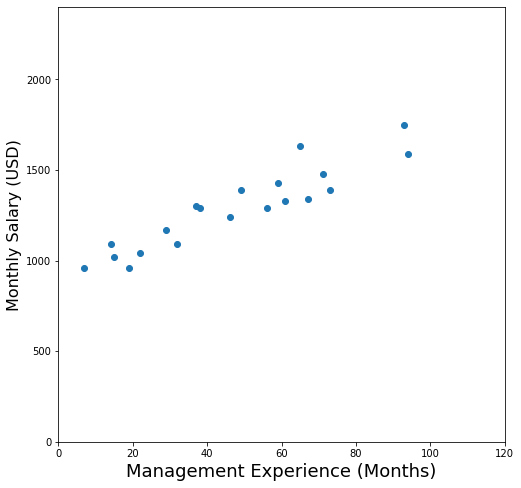

In [7]:
plt.rcParams["figure.figsize"] = (8,8) 
plt.scatter(df_all_data.management_experience_months, df_all_data.monthly_salary)
plt.xlabel('Management Experience (Months)', fontsize=18) 
plt.ylabel('Monthly Salary (USD)', fontsize=16) 
plt.xlim(0, 120)
plt.ylim(0, 2400)

In [8]:
from sklearn.model_selection import train_test_split

X = df_all_data['management_experience_months'].values 
y = df_all_data['monthly_salary'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, random_state=0
)

In [9]:
import pandas as pd

df_training_data = pd.DataFrame({ 
    'monthly_salary': y_train, 
    'management_experience_months': X_train
})

df_training_data

,monthly_salary,management_experience_months
0,1020,15
1,1390,49
2,1590,94
3,1290,38
4,1750,93
5,1240,46
6,960,7
7,1290,56
8,960,19
9,1340,67


In [10]:
df_training_data.to_csv(
    'tmp/training_data.csv', 
    header=False, index=False
)

In [11]:
s3_bucket = 'sagemaker-cookbook-bucket'
prefix = 'chapter09'

In [12]:
!aws s3 cp tmp/training_data.csv s3://{s3_bucket}/{prefix}/input/training_data.csv

upload: tmp/training_data.csv to s3://sagemaker-cookbook-bucket/chapter09/input/training_data.csv


In [13]:
import sagemaker 
import boto3
from sagemaker import get_execution_role 

role = get_execution_role()
session = sagemaker.Session()
region_name = boto3.Session().region_name

In [14]:
training_s3_input_location = f"s3://{s3_bucket}/{prefix}/input/training_data.csv" 
training_s3_output_location = f"s3://{s3_bucket}/{prefix}/output/"

In [16]:
from sagemaker.inputs import TrainingInput

train = TrainingInput(
    training_s3_input_location, 
    content_type="text/csv"
)

In [17]:
from sagemaker.image_uris import retrieve 

container = retrieve(
    "linear-learner", 
    region_name, "1"
)

container

'382416733822.dkr.ecr.us-east-1.amazonaws.com/linear-learner:1'

In [18]:
estimator = sagemaker.estimator.Estimator(
    container,
    role, 
    instance_count=1, 
    instance_type='ml.m5.xlarge',
    output_path=training_s3_output_location,
    sagemaker_session=session
)

In [19]:
estimator.set_hyperparameters(
    predictor_type='regressor', 
    mini_batch_size=4
)

In [20]:
!pip -q install --upgrade stepfunctions

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [66]:
step_functions_workflow_execution_role = 'arn:aws:iam::581320662326:role/test-002'

In [67]:
from stepfunctions.inputs import ExecutionInput

In [68]:
step_functions_execution_input = ExecutionInput(schema={ 
    'ModelName': str,
    'EndpointName': str,
    'JobName': str
})

In [69]:
from stepfunctions.steps import TrainingStep

In [70]:
step_functions_training_step = TrainingStep(
    'Training Step', 
    estimator=estimator,
    data={
        'train': train
    },
    job_name=step_functions_execution_input['JobName']
)

In [71]:
from stepfunctions.steps import ModelStep

In [72]:
step_functions_model_step = ModelStep(
    'Model Step',
    model=step_functions_training_step.get_expected_model(),
    model_name=step_functions_execution_input['ModelName']  
)

In [73]:
from stepfunctions.steps import EndpointConfigStep

In [74]:
step_functions_endpoint_config_step = EndpointConfigStep(
    "Create Endpoint Configuration",
    endpoint_config_name=step_functions_execution_input['ModelName'],
    model_name=step_functions_execution_input['ModelName'],
    initial_instance_count=1,
    instance_type='ml.m5.xlarge'
)

In [75]:
from stepfunctions.steps import EndpointStep

In [76]:
step_functions_endpoint_step = EndpointStep(
    "Deploy Endpoint",
    endpoint_name=step_functions_execution_input['EndpointName'],
    endpoint_config_name=step_functions_execution_input['ModelName']
)

In [77]:
from stepfunctions.steps import Chain

In [78]:
step_functions_workflow_definition = Chain([
    step_functions_training_step,
    step_functions_model_step,
    step_functions_endpoint_config_step,
    step_functions_endpoint_step
])

In [79]:
import uuid

uuid.uuid4().hex

'5d7eddb583b6453caf12c3fadc03a77f'

In [80]:
def generate_random_string():
    return uuid.uuid4().hex

In [81]:
import uuid
from stepfunctions.workflow import Workflow

workflow = Workflow(
    name='{}-{}'.format('Workflow', generate_random_string()),
    definition=step_functions_workflow_definition,
    role=step_functions_workflow_execution_role,
    execution_input=step_functions_execution_input
)

In [82]:
workflow.create()

'arn:aws:states:us-east-1:581320662326:stateMachine:Workflow-304090485ef14af58baf3c3db161356c'

In [83]:
execution = workflow.execute(
    inputs={
        'JobName': 'linear-learner-{}'.format(generate_random_string()),
        'ModelName': 'linear-learner-{}'.format(generate_random_string()),
        'EndpointName': 'linear-learner-{}'.format(generate_random_string())
    }
)

In [91]:
execution.list_events()

[{'timestamp': datetime.datetime(2021, 6, 7, 19, 31, 4, 586000, tzinfo=tzlocal()),
  'type': 'ExecutionStarted',
  'id': 1,
  'previousEventId': 0,
  'executionStartedEventDetails': {'input': '{\n    "JobName": "linear-learner-02646725d03448a1b7c6cbc75989ec4c",\n    "ModelName": "linear-learner-240b27e55c2b4f22b1dd46836c65b901",\n    "EndpointName": "linear-learner-9c4616bd0deb4db8a1c7bf172149a670"\n}',
   'inputDetails': {'truncated': False},
   'roleArn': 'arn:aws:iam::581320662326:role/test-002'}},
 {'timestamp': datetime.datetime(2021, 6, 7, 19, 31, 4, 619000, tzinfo=tzlocal()),
  'type': 'TaskStateEntered',
  'id': 2,
  'previousEventId': 0,
  'stateEnteredEventDetails': {'name': 'Training Step',
   'input': '{\n    "JobName": "linear-learner-02646725d03448a1b7c6cbc75989ec4c",\n    "ModelName": "linear-learner-240b27e55c2b4f22b1dd46836c65b901",\n    "EndpointName": "linear-learner-9c4616bd0deb4db8a1c7bf172149a670"\n}',
   'inputDetails': {'truncated': False}}},
 {'timestamp': date

In [92]:
import pandas as pd

In [93]:
events = execution.list_events()
pd.json_normalize(events)

,timestamp,type,id,previousEventId,executionStartedEventDetails.input,executionStartedEventDetails.inputDetails.truncated,executionStartedEventDetails.roleArn,stateEnteredEventDetails.name,stateEnteredEventDetails.input,stateEnteredEventDetails.inputDetails.truncated,...,taskSubmittedEventDetails.outputDetails.truncated,taskSucceededEventDetails.resourceType,taskSucceededEventDetails.resource,taskSucceededEventDetails.output,taskSucceededEventDetails.outputDetails.truncated,stateExitedEventDetails.name,stateExitedEventDetails.output,stateExitedEventDetails.outputDetails.truncated,executionSucceededEventDetails.output,executionSucceededEventDetails.outputDetails.truncated
0,2021-06-07 19:31:04.586000+00:00,ExecutionStarted,1,0,"{\n ""JobName"": ""linear-learner-02646725d034...",False,arn:aws:iam::581320662326:role/test-002,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-06-07 19:31:04.619000+00:00,TaskStateEntered,2,0,NaN,NaN,NaN,Training Step,"{\n ""JobName"": ""linear-learner-02646725d034...",False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-06-07 19:31:04.619000+00:00,TaskScheduled,3,2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-06-07 19:31:05+00:00,TaskStarted,4,3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-06-07 19:31:05.338000+00:00,TaskSubmitted,5,4,NaN,NaN,NaN,NaN,NaN,NaN,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2021-06-07 19:34:04.650000+00:00,TaskSucceeded,6,5,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,sagemaker,createTrainingJob.sync,"{""AlgorithmSpecification"":{""EnableSageMakerMet...",False,NaN,NaN,NaN,NaN,NaN
6,2021-06-07 19:34:04.650000+00:00,TaskStateExited,7,6,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Training Step,"{""AlgorithmSpecification"":{""EnableSageMakerMet...",False,NaN,NaN
7,2021-06-07 19:34:04.659000+00:00,TaskStateEntered,8,7,NaN,NaN,NaN,Model Step,"{""AlgorithmSpecification"":{""EnableSageMakerMet...",False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2021-06-07 19:34:04.659000+00:00,TaskScheduled,9,8,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2021-06-07 19:34:04.674000+00:00,TaskStarted,10,9,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [94]:
workflow.__dict__

{'timeout_seconds': None,
 'comment': None,
 'version': None,
 'definition': Graph(timeout_seconds=None, comment=None, version=None),
 'name': 'Workflow-304090485ef14af58baf3c3db161356c',
 'role': 'arn:aws:iam::581320662326:role/test-002',
 'tags': [],
 'workflow_input': <stepfunctions.inputs.placeholders.ExecutionInput at 0x7fd70fe14f50>,
 'client': <botocore.client.SFN at 0x7fd70df8ae10>,
 'format_json': True,
 'state_machine_arn': 'arn:aws:states:us-east-1:581320662326:stateMachine:Workflow-304090485ef14af58baf3c3db161356c'}

In [98]:
print(workflow.definition.to_json(pretty=True))

{
    "StartAt": "Training Step",
    "States": {
        "Training Step": {
            "Resource": "arn:aws:states:::sagemaker:createTrainingJob.sync",
            "Parameters": {
                "AlgorithmSpecification": {
                    "TrainingImage": "382416733822.dkr.ecr.us-east-1.amazonaws.com/linear-learner:1",
                    "TrainingInputMode": "File"
                },
                "OutputDataConfig": {
                    "S3OutputPath": "s3://sagemaker-cookbook-bucket/chapter09/output/"
                },
                "StoppingCondition": {
                    "MaxRuntimeInSeconds": 86400
                },
                "ResourceConfig": {
                    "InstanceCount": 1,
                    "InstanceType": "ml.m5.xlarge",
                    "VolumeSizeInGB": 30
                },
                "RoleArn": "arn:aws:iam::581320662326:role/SuperAdminRole",
                "InputDataConfig": [
                    {
                        "DataSo